In [ ]:
import kagglehub
import pandas

# Download latest version
path = kagglehub.dataset_download("janiobachmann/bank-marketing-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'bank-marketing-dataset' dataset.
Path to dataset files: /kaggle/input/bank-marketing-dataset


In [ ]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer

In [ ]:
# The `path` variable points to the directory of the downloaded files.
# We are interested in the `bank.csv` file specifically.
filepath = Path(path) / Path("bank.csv")

data = pd.read_csv(filepath)

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


Text(0.5, 1.0, "Distribution of target variable 'deposit'")

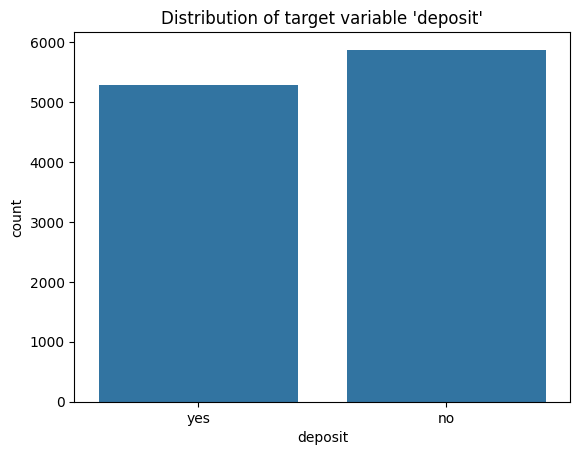

In [ ]:
sns.countplot(data=data, x="deposit")
plt.title("Distribution of target variable 'deposit'")

In [ ]:

data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.00,95.0
balance,11162.0,1528.538524,3225.413326,-6847.0,122.0,550.0,1708.00,81204.0
day,11162.0,15.658036,8.420740,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.330407,108.758282,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.00,58.0


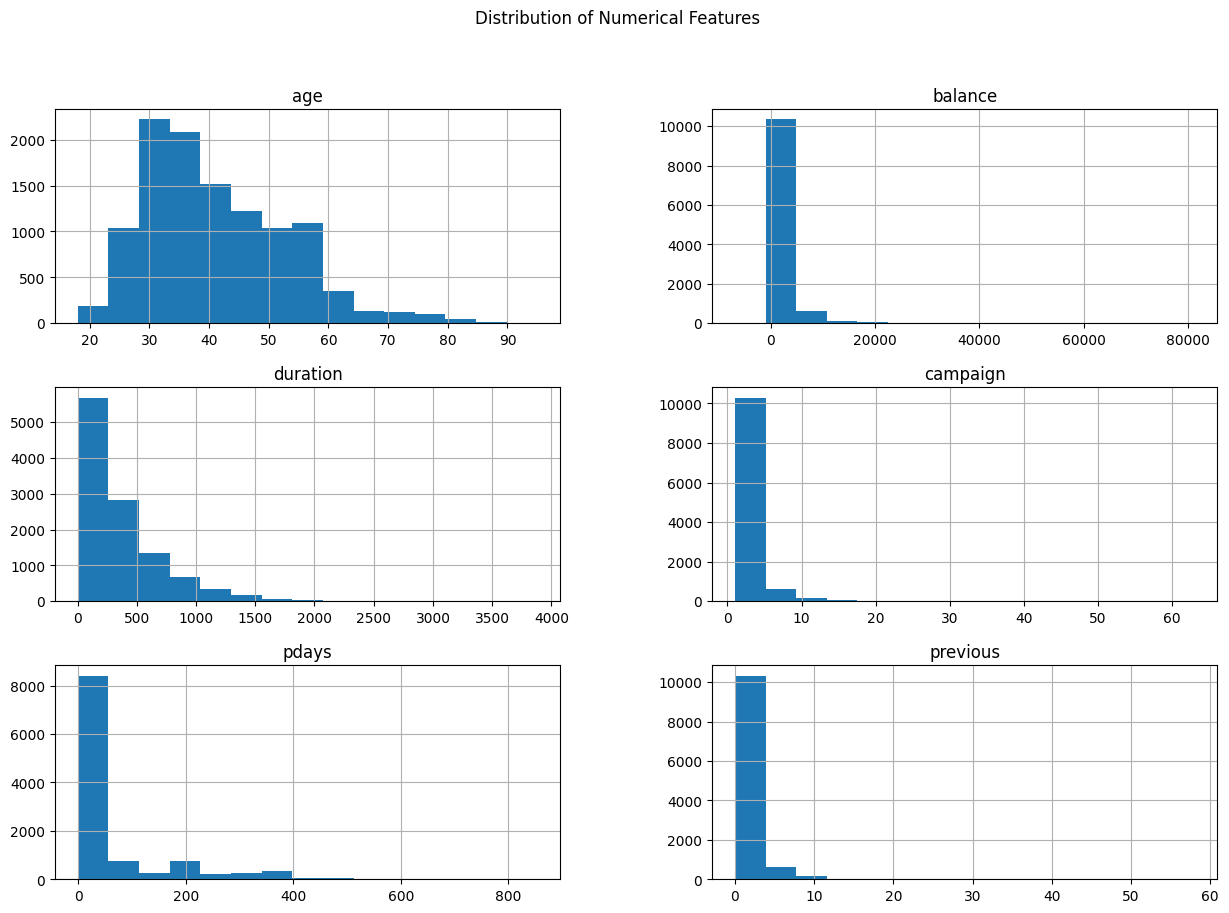

In [ ]:
numerical_features = ["age", "balance", "duration", "campaign", "pdays", "previous"]

data[numerical_features].hist(bins=15, figsize=(15, 10))
plt.suptitle("Distribution of Numerical Features")
plt.show()

##Métrica de Selección
La elección de Recall se justifica porque, en una campaña de captación de depósitos, el costo de oportunidad de perder a un cliente dispuesto a contratar el producto (Falso Negativo) es significativamente mayor que el costo operativo de realizar una llamada a alguien que finalmente no lo contrata (Falso Positivo). Al optimizar esta métrica, el banco asegura la máxima captación de capital al identificar a la mayor cantidad posible de clientes potenciales, priorizando el crecimiento de la cartera y el retorno de inversión sobre la eficiencia extrema de los contactos.

##1. Definición del Preprocesamiento
Primero, separaremos las columnas y crearemos el transformador.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Hacemos una copia para trabajar seguros
df_model = data.copy()

# 1. Mapeos manuales (Ordinal Encoding)
df_model["month"] = df_model["month"].map({
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})

df_model["education"] = df_model["education"].map({
    'primary': 1, 'secondary': 2, 'tertiary': 3, 'unknown': 2}) # 2 es la moda

binary_cols = ["default", "housing", "loan"]
for col in binary_cols:
    df_model[col] = df_model[col].map({"yes": 1, "no": 0})

# 2. Selección de variables (Eliminamos duration y otras problemáticas)
# X incluirá las mapeadas (month, education, etc) + las que procesará el ColumnTransformer
X = df_model.drop(columns=["deposit", "duration", "pdays", "poutcome"])
y = df_model["deposit"].map({"yes": 1, "no": 0})

# 3. Definición de columnas para el Transformer
num_cols = ["age", "balance", "campaign", "previous"]
cat_cols = ["marital", "contact", "job"] # Únicas que quedan como texto

preprocessing = ColumnTransformer(
    transformers=[
        ("num", make_pipeline(SimpleImputer(strategy="median"), PowerTransformer()), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="passthrough" # Pasan: month, education, default, housing, loan
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##2. Configuración de Modelos y Grid Search
Prepararemos un diccionario con los modelos y sus parámetros para iterar sobre ellos.

In [ ]:
models_config = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'logisticregression__C': [0.1, 1, 10],
            'logisticregression__solver': ['lbfgs', 'liblinear']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'randomforestclassifier__n_estimators': [100, 200],
            'randomforestclassifier__max_depth': [None, 10, 20]
        }
    },
    'SVM': {
        'model': SVC(probability=True),
        'params': {
            'svc__C': [0.1, 1, 10],
            'svc__kernel': ['rbf', 'linear']
        }
    }
}

best_models = {}

for name, config in models_config.items():
    pipeline = make_pipeline(preprocessing, config['model'])
    grid = GridSearchCV(pipeline, config['params'], cv=5, scoring='recall', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_models[name] = grid.best_estimator_
    print(f"Mejor Recall en CV para {name}: {grid.best_score_:.4f}")

Mejor Recall en CV para LogisticRegression: 0.6469
Mejor Recall en CV para RandomForest: 0.6502
Mejor Recall en CV para SVM: 0.6384


##Ejecución y Comparación Final


--- RESULTADOS EN SET DE PRUEBA ---
Recall LogisticRegression: 0.6229
Recall RandomForest: 0.6238
Recall SVM: 0.6068

ANÁLISIS DETALLADO: RandomForest


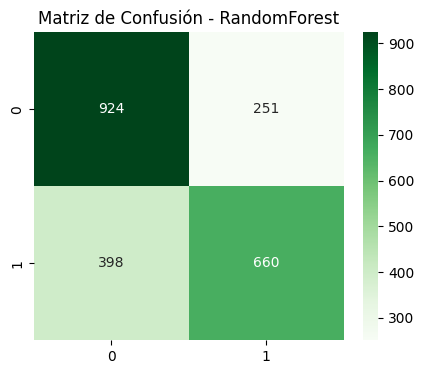

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      1175
           1       0.72      0.62      0.67      1058

    accuracy                           0.71      2233
   macro avg       0.71      0.71      0.71      2233
weighted avg       0.71      0.71      0.71      2233



In [ ]:
from sklearn.metrics import recall_score

print("\n--- RESULTADOS EN SET DE PRUEBA ---")
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"Recall {name}: {recall_score(y_test, y_pred):.4f}")

# Elige el mejor automáticamente
best_name = max(best_models, key=lambda k: recall_score(y_test, best_models[k].predict(X_test)))
best_model = best_models[best_name]

print(f"\nANÁLISIS DETALLADO: {best_name}")
y_pred_best = best_model.predict(X_test)

# Matriz de Confusión
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Greens')
plt.title(f"Matriz de Confusión - {best_name}")
plt.show()

# Reporte
print(classification_report(y_test, y_pred_best))

##Reporte del Mejor Modelo

El mejor modelo identificado es: RandomForest
Recall en prueba: 0.6238


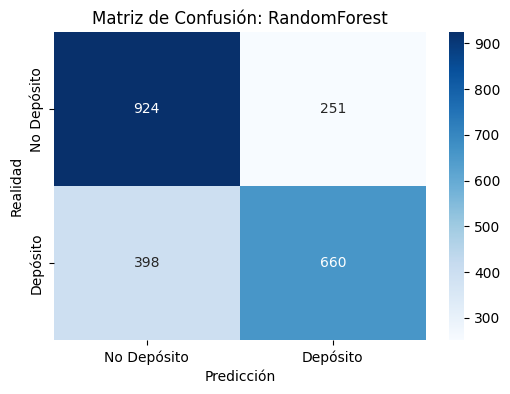


--- Reporte de Clasificación Final ---
              precision    recall  f1-score   support

           0       0.70      0.79      0.74      1175
           1       0.72      0.62      0.67      1058

    accuracy                           0.71      2233
   macro avg       0.71      0.71      0.71      2233
weighted avg       0.71      0.71      0.71      2233



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score, classification_report, confusion_matrix

# 1. Identificar el mejor modelo basado en el Recall del set de prueba
test_recalls = {name: recall_score(y_test, model.predict(X_test)) for name, model in best_models.items()}
best_model_name = max(test_recalls, key=test_recalls.get)

print(f"El mejor modelo identificado es: {best_model_name}")
print(f"Recall en prueba: {test_recalls[best_model_name]:.4f}")

# 2. Extraer el mejor modelo y predecir
best_overall_model = best_models[best_model_name]
y_pred_best = best_overall_model.predict(X_test)

# 3. Visualización: Matriz de Confusión
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Depósito', 'Depósito'],
            yticklabels=['No Depósito', 'Depósito'])
plt.title(f"Matriz de Confusión: {best_model_name}")
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()

# 4. Reporte de Clasificación
print("\n--- Reporte de Clasificación Final ---")
print(classification_report(y_test, y_pred_best))

##Conclusión General

El Random Forest es el modelo más eficiente con un Recall de 0.6238, cumpliendo el objetivo de minimizar los falsos negativos para no perder clientes dispuestos a realizar depósitos. Aunque este enfoque genera llamadas adicionales a usuarios que no aceptarán la oferta (falsos positivos), se justifica porque el beneficio de asegurar una conversión supera el costo operativo de los contactos innecesarios, optimizando así el retorno de inversión de la campaña.